# 8760 Notebook

### Imports

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cftime
import xarray as xr
import os
import hvplot.xarray
import holoviews as hv
import panel as pn
from typing import List, Union, Tuple
from datetime import timedelta
from climakitae.explore.vulnerability import cava_data
from climakitae.util.utils import add_dummy_time_to_wl
from climakitae.explore.threshold_tools import (
    get_block_maxima,
    get_return_value,
    get_ks_stat,
    _get_fitted_distr,
    _calculate_return,
    _conf_int,
    _get_distr_func,
)
from phase3 import *
random.seed(35)

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

### Global Variables

In [3]:
# Putting locations into a DataFrame
locations = {
    "goleta": (34.486652, -119.894310),
    "iv": (34.427741, -119.855950),
    "sb_mountains": (34.518453, -119.799645),
    "valencia": (34.432468, -118.571098),
    "castaic": (34.492141, -118.605053),
    "lebec": (34.680102, -118.789246),
}

df = pd.DataFrame.from_dict(locations, orient='index', columns=['lat', 'lon']).reset_index()
df.rename(columns={'index': 'location'}, inplace=True)

In [4]:
# Santa Barbara area
sb = df.iloc[:3][['lat', 'lon']]
sb_locs = ['goleta', 'iv', 'sb_mountains']

# Santa Clarita area
sc = df.iloc[3:6][['lat', 'lon']]
sc_locs = ['valencia', 'castaic', 'lebec']

In [5]:
# Set params for 1-in-X calculations
one_in_x = np.array([10, 100])
event_duration = (1, 'day')
distr = 'gev'

# --- Calculations/Plotting Begin Here ---

In [6]:
### Retrieving saved files for SB/SC locations, or generating the data from scratch if not available locally
sb_files = [
    'one_in_10-100_temperature_raw_data_34495N_-119882W.nc',
    'one_in_10-100_temperature_raw_data_34434N_-11987W.nc',
    'one_in_10-100_temperature_raw_data_3452N_-119782W.nc'
]
sc_files = [
    'one_in_10-100_temperature_raw_data_34425N_-118559W.nc',
    'one_in_10-100_temperature_raw_data_34492N_-118616W.nc',
    'one_in_10-100_temperature_raw_data_34695N_-118788W.nc',
]

clean_raw_data_sb = retrieve_data(sb_locs, sb, sb_files, 'SB')
clean_raw_data_sc = retrieve_data(sc_locs, sc, sc_files, 'SC')

Attempting to load saved SB files...


/home/jovyan/curr-cae-notebooks/collaborative/IOU/8760/phase3.py:158: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  total_raw['time'] = xr.cftime_range(


Attempting to load saved SC files...


/home/jovyan/curr-cae-notebooks/collaborative/IOU/8760/phase3.py:158: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  total_raw['time'] = xr.cftime_range(


### Calculating 1-in-X events

In [7]:
%%time
# Calculating the 1-in-X return values, and lower + upper CIs, for SB locations
all_one_in_x_sb = get_one_in_x(clean_raw_data_sb, one_in_x, event_duration, distr, 'max')
calc_data_sb = all_one_in_x_sb['return_value']

CPU times: user 29.4 s, sys: 24.3 ms, total: 29.4 s
Wall time: 29.3 s


In [8]:
%%time
# Calculating the 1-in-X return values, and lower + upper CIs, for SC locations
all_one_in_x_sc = get_one_in_x(clean_raw_data_sc, one_in_x, event_duration, distr, 'max')
calc_data_sc = all_one_in_x_sc['return_value']

CPU times: user 21.3 s, sys: 3.99 ms, total: 21.3 s
Wall time: 21.2 s


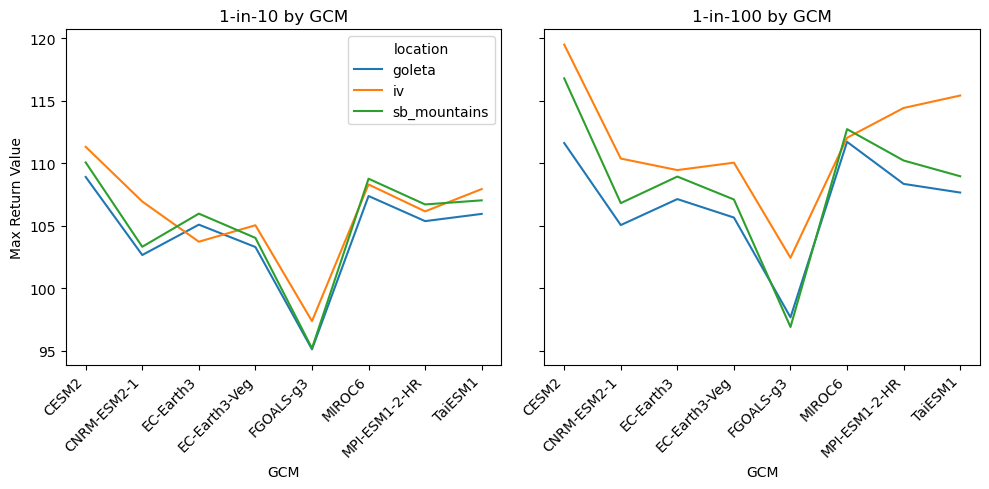

In [9]:
# Plotting the 1-in-X values by simulation for Santa Barbara locations
plot_retvals(calc_data_sb)

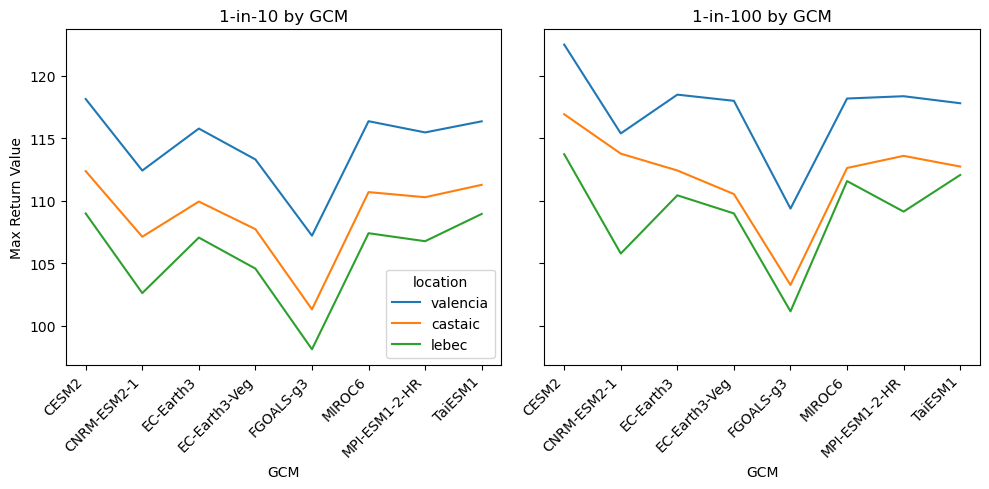

In [10]:
# Plotting the 1-in-X values by simulation for Santa Clarita locations
plot_retvals(calc_data_sc)

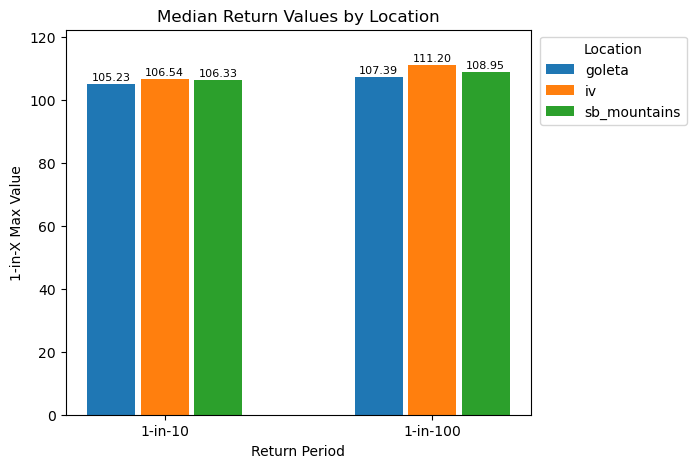

In [11]:
# Finding the median of the above plots along simulation dimension
plot_med_val_by_locs(calc_data_sb)

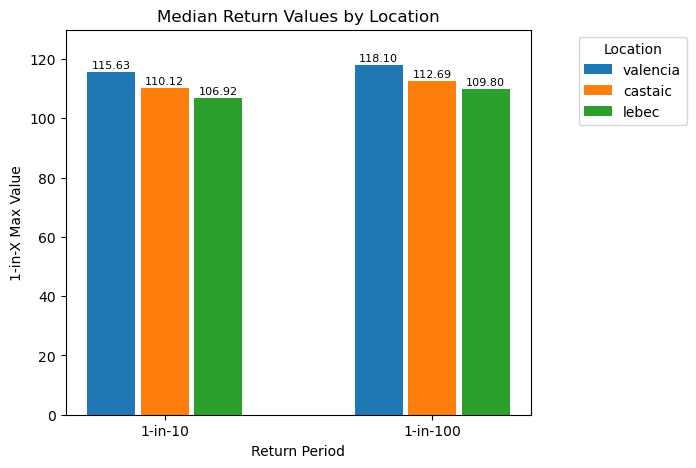

In [12]:
plot_med_val_by_locs(calc_data_sc)

# Inserting `time` amount of 1-in-X timesteps into 8760s

### Setting a number of +/- days for `ramp up` and `ramp down`, creating modified 8760s, and plotting them 

In [13]:
# Setting param for number of +/- number of days to 'ramp up' and 'ramp down' by
t = 7

#### Here, we will look into how you can create a `modified8760` using the calculated median times to insert these 1-in-X events, and using the times that a user passes in.

#### 1. Using calculated median times to insert 1-in-X events into

In [19]:
# Create a modified 8760 that injects 1-in-X events into the median times these events occur by location
modified8760_sb = create_modified_8760(clean_raw_data_sb, all_one_in_x_sb, t)

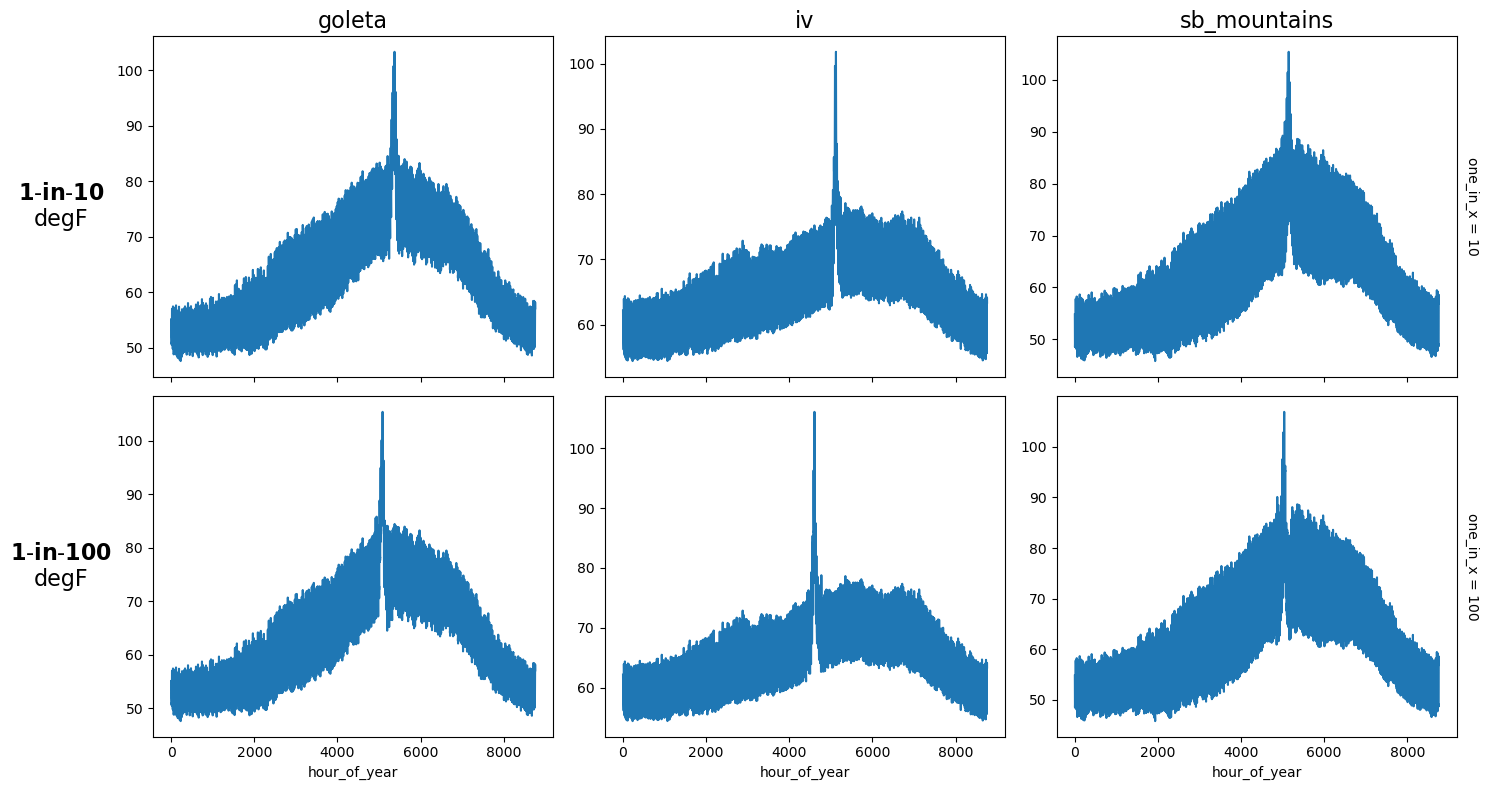

In [20]:
# Plot the modified 8760 to see the events inserted!
plot_modified8760s(modified8760_sb)

#### 2. Insert 1-in-X events at times that users pre-define

In [21]:
# This creates a dummy DataArray that follows the data shape needed to specify custom times
dummy_times = create_empty_da(all_one_in_x_sb['return_value'], keep_dims=['location', 'one_in_x'])

In [22]:
# Here, you can manually change the values from `custom_times` to set specific times for these `one_in_x` events to occur.
# `updates` can either be a list of dictionaries (if you're looking to set these different events at different times, or you can
# set `updates` to a singular number to have all the events be inserted at the same time

updates = [
    {'location': 'goleta', 'one_in_x': 10, 'value': 1000},
    {'location': 'iv', 'one_in_x': 100, 'value': 1000}
]

# OR YOU CAN DO
updates = 3000

custom_times = set_custom_times(dummy_times, updates)

In [23]:
# Calculates the modified 8760 with 1-in-X events inserted at custom times
modified8760_sb = create_modified_8760(clean_raw_data_sb, all_one_in_x_sb, t, custom_times=custom_times)

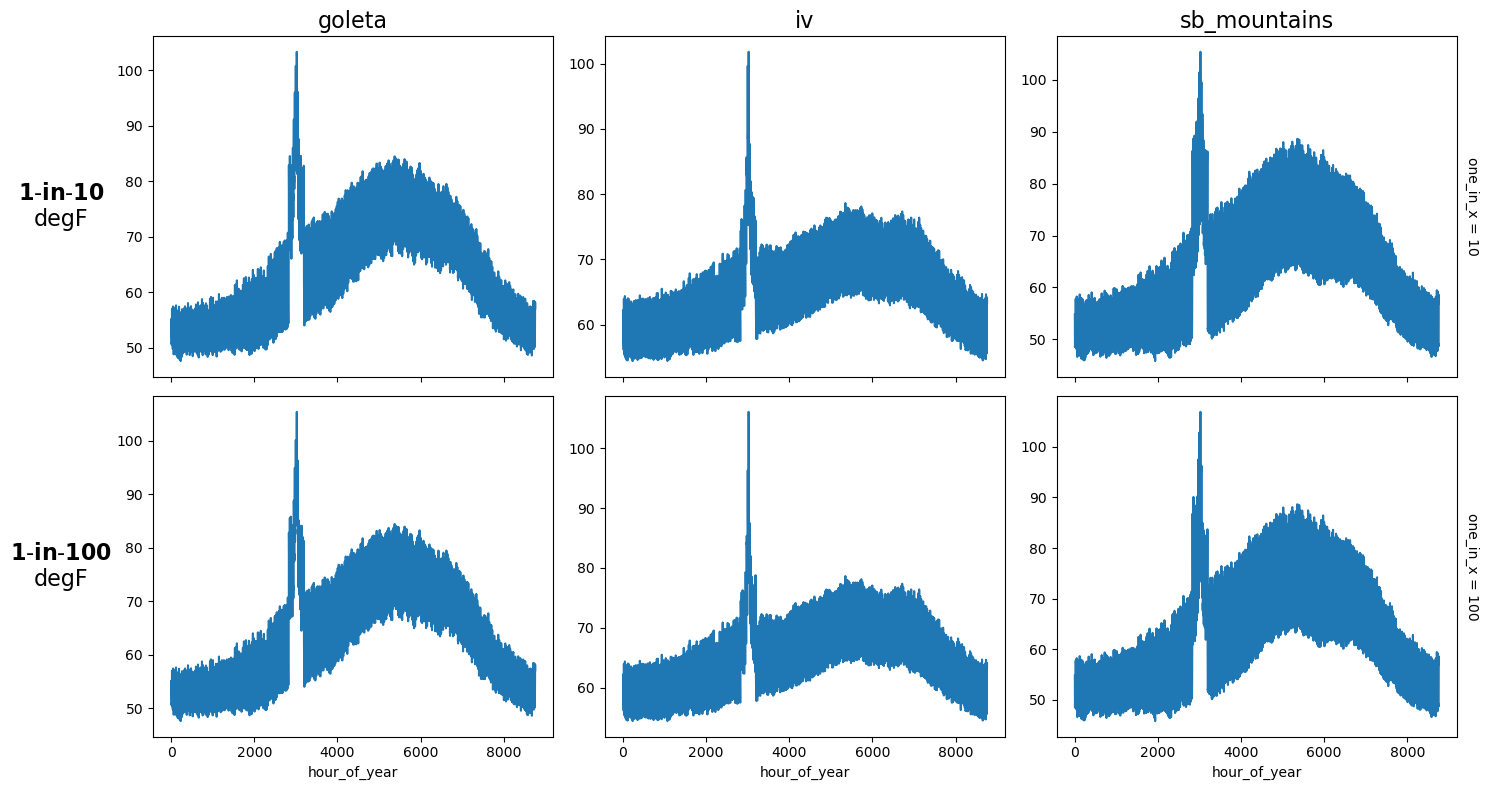

In [24]:
plot_modified8760s(modified8760_sb)

### Inserting a min 1-in-X event into already modified 8760

Here, we will go through inserting another 1-in-X event into an already modified 8760, to showcase an 8760 timeseries with both a 1-in-X max temp and a 1-in-X min event inserted.

In [25]:
%%time
# Calculating the 1-in-X min events,, and lower + upper CIs, for SB locations
sb_one_in_x_min = get_one_in_x(clean_raw_data_sb, one_in_x, event_duration, distr, 'min')

CPU times: user 34.3 s, sys: 13.9 ms, total: 34.3 s
Wall time: 34.2 s


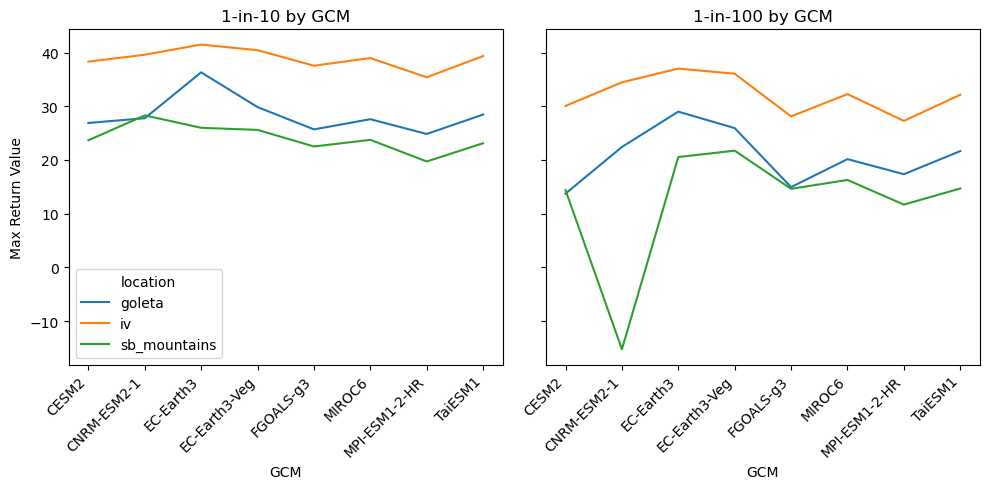

In [26]:
# Plotting the 1-in-X values by simulation for Santa Barbara locations
plot_retvals(sb_one_in_x_min['return_value'])

In [27]:
%%time
# Calculating the 1-in-X min events,, and lower + upper CIs, for SB locations
sb_one_in_x_min = get_one_in_x(clean_raw_data_sb, one_in_x, event_duration, distr, 'min')

CPU times: user 30.1 s, sys: 8.66 ms, total: 30.1 s
Wall time: 30.1 s


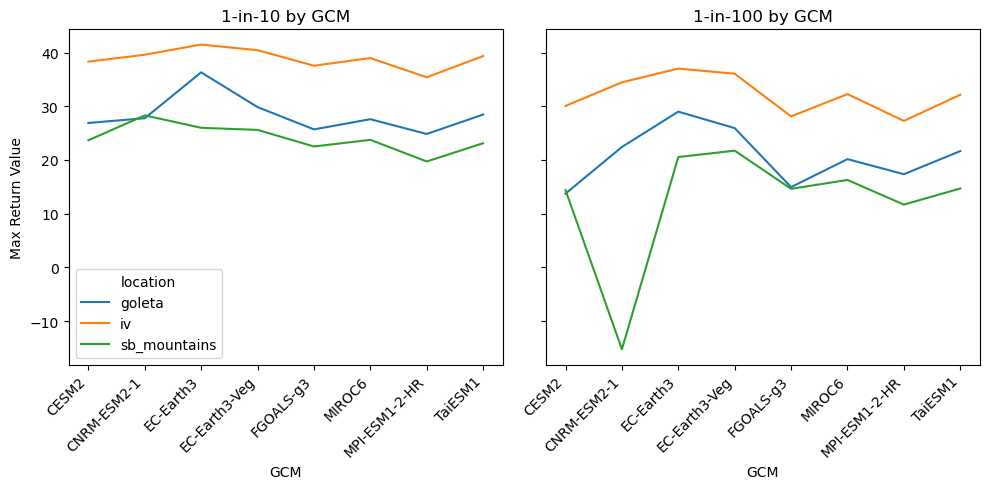

In [28]:
# Plotting the 1-in-X values by simulation for Santa Barbara locations
plot_retvals(sb_one_in_x_min['return_value'])

In [29]:
# Custom inserting events at hour=1000
updates = 1000
custom_times = set_custom_times(dummy_times, updates)

In [30]:
# Insert a min 1-in-X event into already modified 8760
two_events_8760_sb = create_modified_8760(clean_raw_data_sb, sb_one_in_x_min, t, extremes_type='min', custom_times=custom_times, custom_8760=modified8760_sb)

No valid times found for location=goleta, simulation=WRF_CESM2_r11i1p1f1_historical+ssp370, one_in_x=100; returning an empty DataArray.
No valid times found for location=goleta, simulation=WRF_MPI-ESM1-2-HR_r3i1p1f1_historical+ssp370, one_in_x=100; returning an empty DataArray.
No valid times found for location=sb_mountains, simulation=WRF_CESM2_r11i1p1f1_historical+ssp370, one_in_x=100; returning an empty DataArray.
No valid times found for location=sb_mountains, simulation=WRF_EC-Earth3_r1i1p1f1_historical+ssp370, one_in_x=100; returning an empty DataArray.


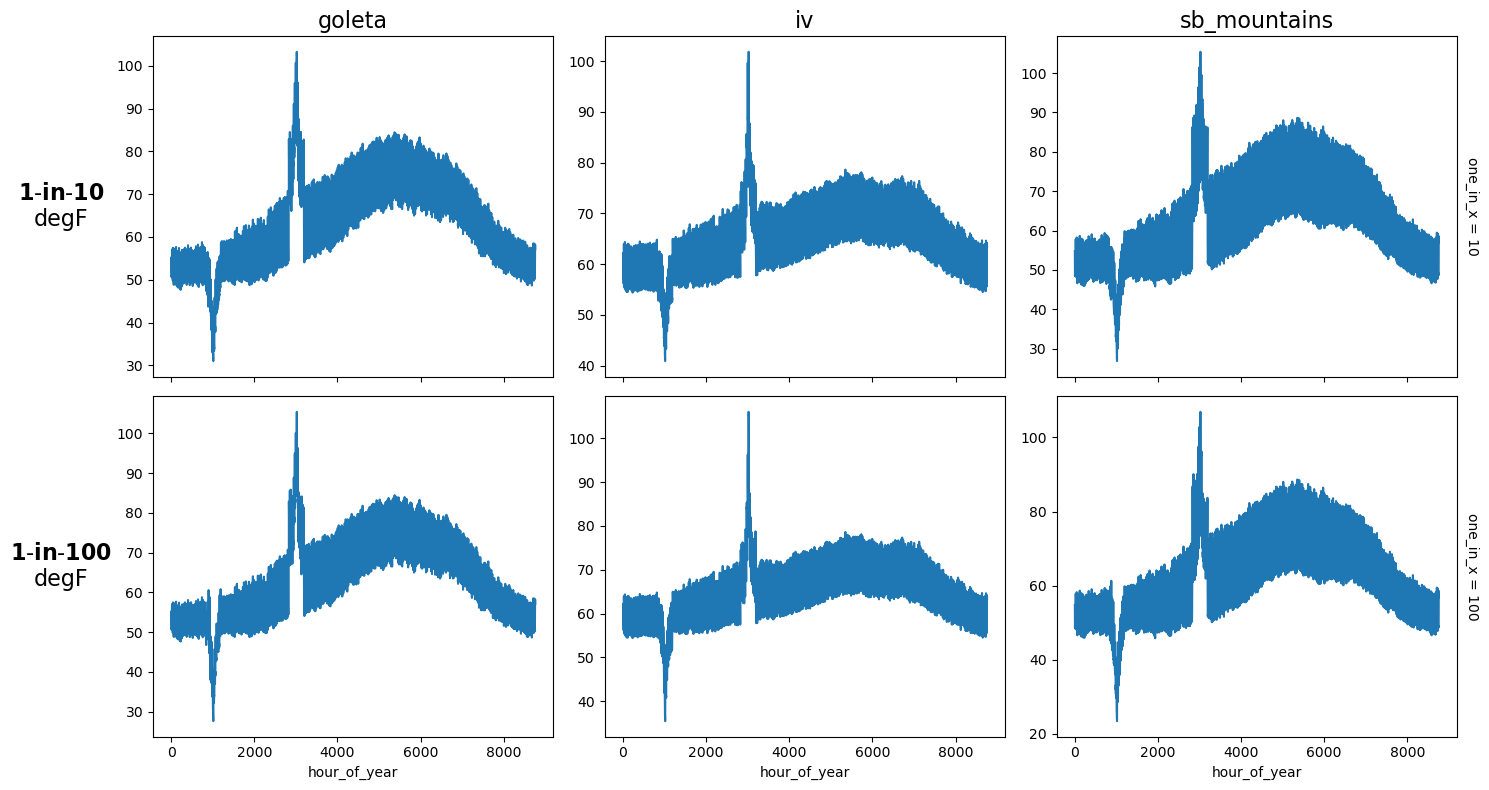

In [31]:
# Plot 8760 with 2 types of 1-in-X events inserted
plot_modified8760s(two_events_8760_sb)

### Do the same for SC, but at hour=6000

In [45]:
# Create `dummy_times` DataArray for SC
dummy_times = create_empty_da(all_one_in_x_sc['return_value'], keep_dims=['location', 'one_in_x'])

In [46]:
# Modify event timing here
updates = 6000
custom_times = set_custom_times(dummy_times, updates)

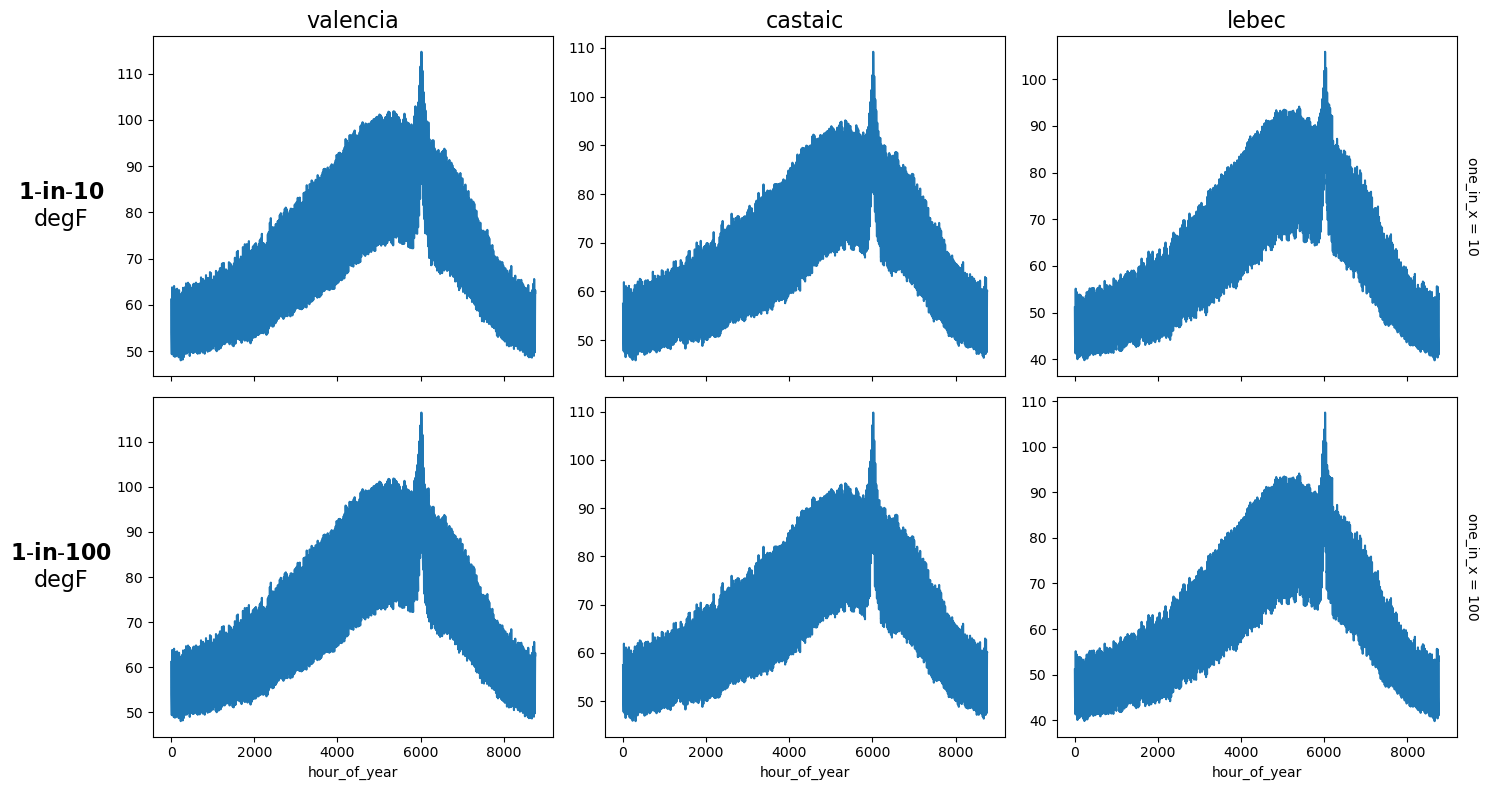

In [47]:
# Create and plot modified 8760 for SC
modified8760_sc = create_modified_8760(clean_raw_data_sc, all_one_in_x_sc, t, custom_times=custom_times)
plot_modified8760s(modified8760_sc)

---

# 

#

### Examining differences between timeseries that fall within max 1-in-X event range vs min 1-in-X range

In [32]:
%%time
# Calculating the 1-in-X return values, and lower + upper CIs, for SB locations
max_events = get_one_in_x(clean_raw_data_sb, one_in_x, event_duration, distr, 'max')

CPU times: user 24.4 s, sys: 9.78 ms, total: 24.4 s
Wall time: 24.3 s


In [33]:
%%time
# Calculating the 1-in-X min events,, and lower + upper CIs, for SB locations
min_events = get_one_in_x(clean_raw_data_sb, one_in_x, event_duration, distr, 'min')

CPU times: user 29.4 s, sys: 3.45 ms, total: 29.4 s
Wall time: 29.3 s


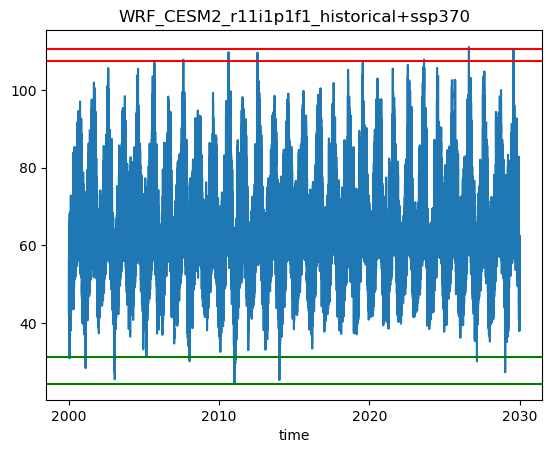

Max: 7.0
Min: 17.0


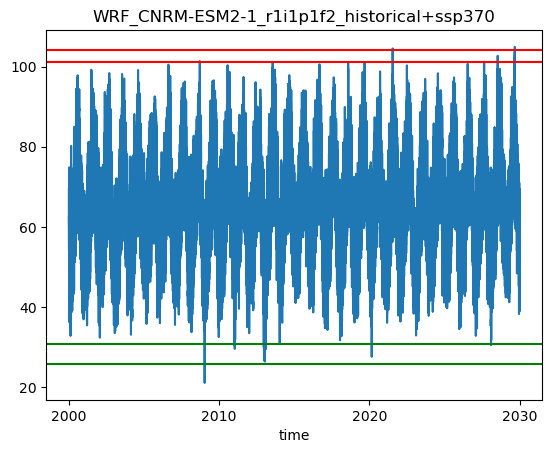

Max: 6.0
Min: 12.0


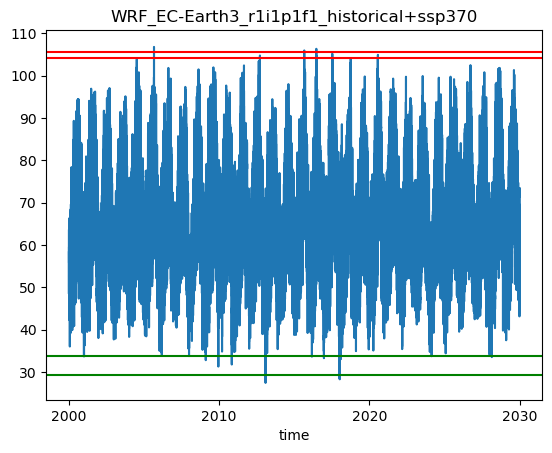

Max: 4.0
Min: 11.0


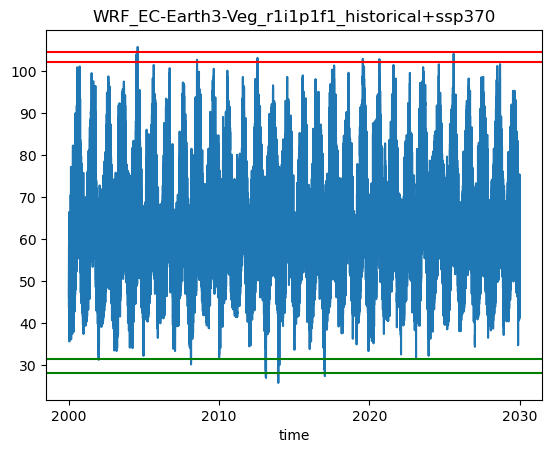

Max: 11.0
Min: 13.0


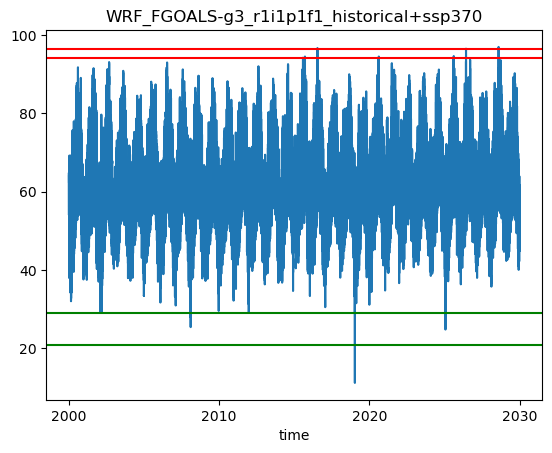

Max: 5.0
Min: 3.0


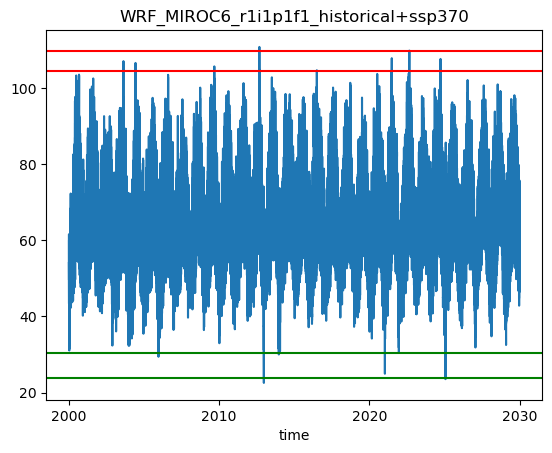

Max: 13.0
Min: 5.0


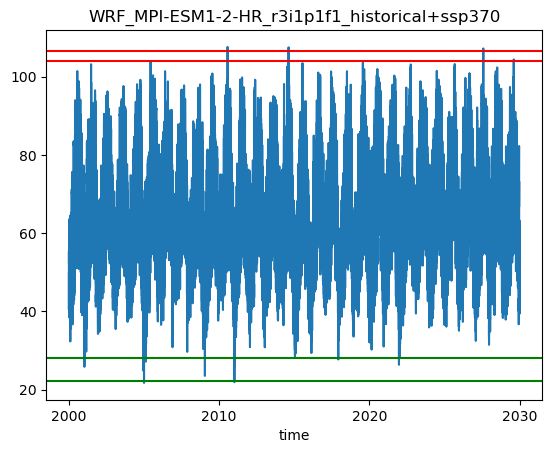

Max: 3.0
Min: 10.0


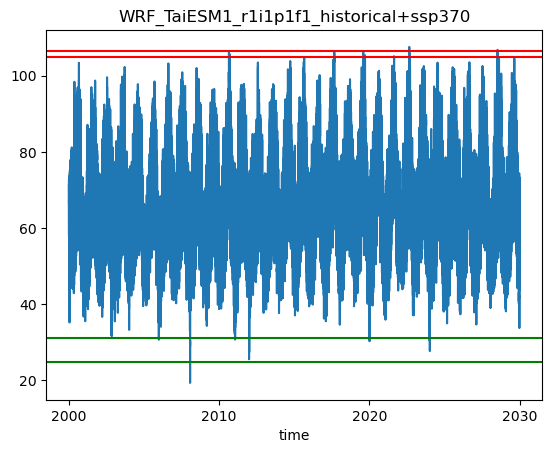

Max: 10.0
Min: 12.0


In [34]:
for sim in max_events.simulation.values:
    vals = max_events.sel(location='goleta').sel(simulation=sim).sel(one_in_x=10)
    lower_max, upper_max = vals['conf_int_lower_limit'], vals['conf_int_upper_limit']

    vals = min_events.sel(location='goleta').sel(simulation=sim).sel(one_in_x=10)
    lower_min, upper_min = vals['conf_int_lower_limit'], vals['conf_int_upper_limit']

    timeseries = clean_raw_data_sb.sel(location='goleta').sel(simulation=sim).squeeze()

    timeseries.plot.line()
    plt.axhline(y=lower_max, color='red')
    plt.axhline(y=upper_max, color='red')
    plt.axhline(y=lower_min, color='green')
    plt.axhline(y=upper_min, color='green')
    plt.title(sim)
    plt.show();

    daily_ds_max = combine_ds(make_clean_daily(clean_raw_data_sb, extremes_type='max'), max_events)
    daily_ds_min = combine_ds(make_clean_daily(clean_raw_data_sb, extremes_type='min'), min_events)
    df_max = gather_valid_times(daily_ds_max)
    df_min = gather_valid_times(daily_ds_min)

    one_sim_max_df = df_max[(df_max['location'] == 'goleta') & (df_max['simulation'] == sim) & (df_max['one_in_x'] == 10)]
    one_sim_min_df = df_min[(df_min['location'] == 'goleta') & (df_min['simulation'] == sim) & (df_min['one_in_x'] == 10)]
    events_max = one_sim_max_df.valid_times.apply(lambda x: len(x)).to_numpy()
    events_min = one_sim_min_df.valid_times.apply(lambda x: len(x)).to_numpy()
    # plt.hist(events, bins=10)
    print(f"Max: {events_max.mean()}")
    print(f"Min: {events_min.mean()}")
    # plt.ylabel('Count')
    # plt.xlabel('Number of events for a location x simulation x one-in-x combination')
    # plt.title('Max 1 in X event count')
    # plt.show();

In [35]:
### Examining `gev` distribution for a single simulation
da = clean_raw_data_sb

bms_min = get_block_maxima(
    da, 
    extremes_type='min', 
    groupby=event_duration, 
    check_ess=False
)

bms_max = get_block_maxima(
    da, 
    extremes_type='max', 
    groupby=event_duration, 
    check_ess=False
)

distr_func = _get_distr_func('gev')

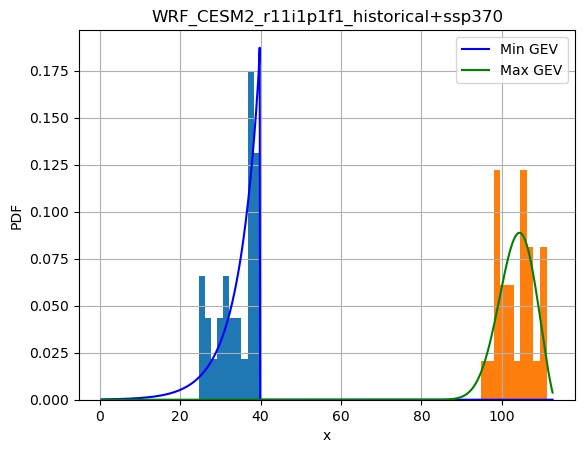

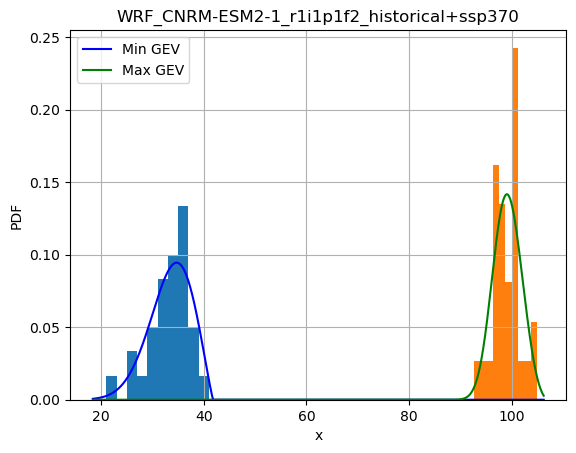

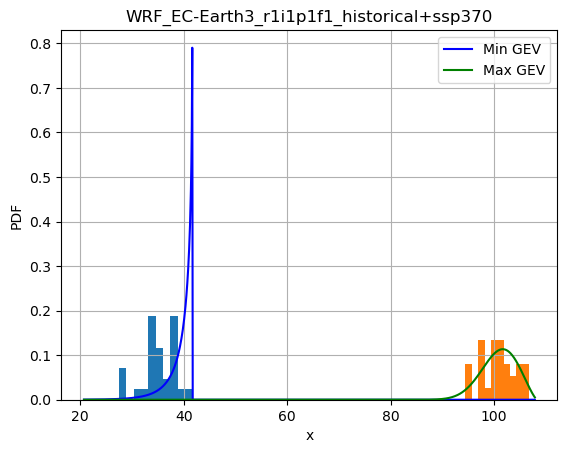

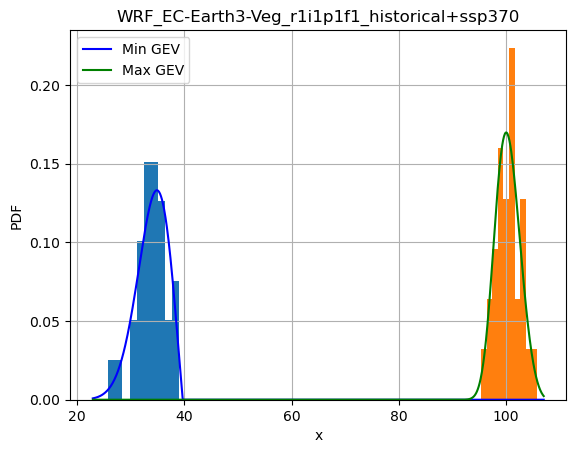

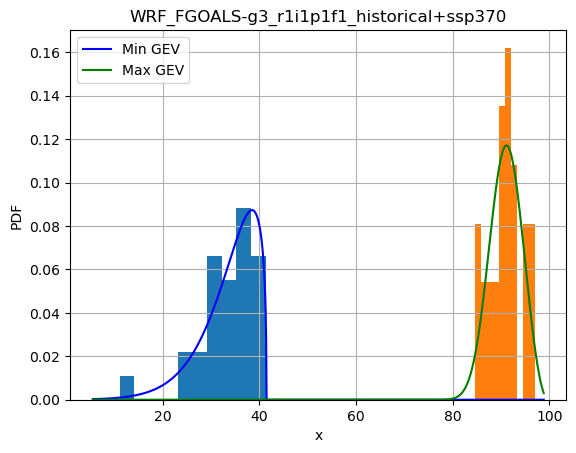

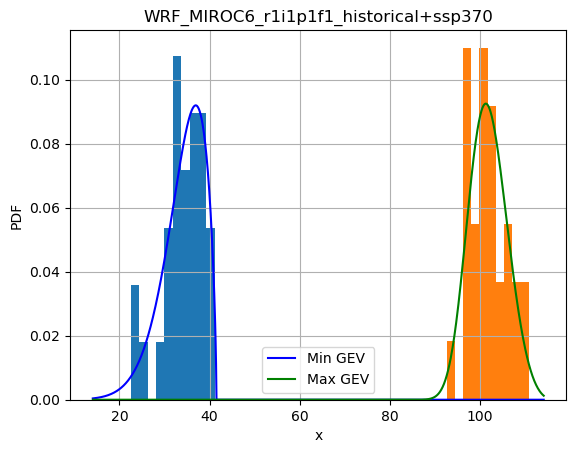

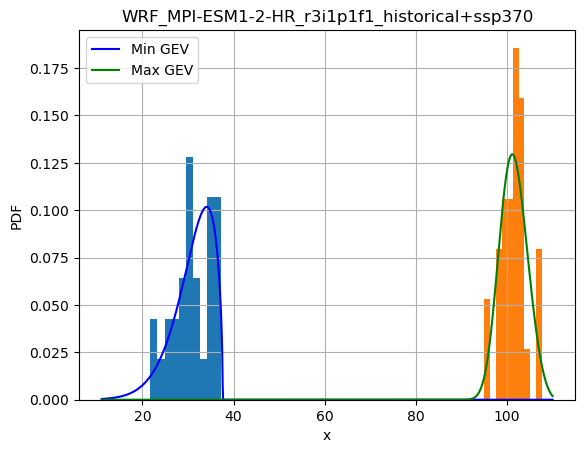

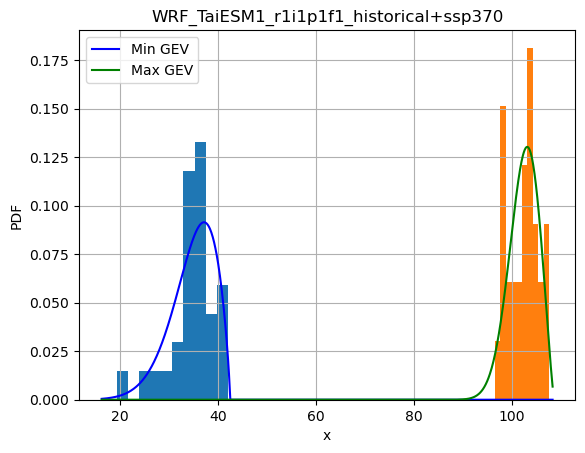

In [36]:
for sim in bms_max.simulation.values:
    one_max = bms_max.sel(location='goleta', simulation=sim).squeeze()
    one_min = bms_min.sel(location='goleta', simulation=sim).squeeze()

    max_distr = _get_fitted_distr(one_max, distr, distr_func)
    min_distr = _get_fitted_distr(one_min, distr, distr_func)

    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.stats import genextreme
    
    # Example GEV frozen distributions
    gev1 = min_distr[1]
    gev2 = max_distr[1]
    
    # Define a common x-range based on both distributions
    x_min = min(gev1.ppf(0.001), gev2.ppf(0.001))
    x_max = max(gev1.ppf(0.999), gev2.ppf(0.999))
    x = np.linspace(x_min, x_max, 1000)
    
    # Plot both PDFs
    plt.plot(x, gev1.pdf(x), label='Min GEV', color='blue')
    plt.plot(x, gev2.pdf(x), label='Max GEV', color='green')

    one_min.plot.hist(density=True)
    one_max.plot.hist(density=True)
    
    # Labels and legend
    plt.title(sim)
    plt.xlabel("x")
    plt.ylabel("PDF")
    plt.grid(True)
    plt.legend()
    plt.show()